In [133]:
import sys
sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import data_frame
import models
from utils import load_config

BINS = np.arange(0, 5, 0.04)
BIN_CENTERS = 0.5 * (BINS[1:] + BINS[:-1])
SAMPLES_N = 1
HISTOGRAM_N = 1000
BURN_IN = 10

config_path = "../configs/config.yml"
config = load_config(config_path)

filePath = "../../KiDS-DR5-WCScut_x_DESI-DR1-small.fits"

df = data_frame.DataFrame(filePath, "QSO", data_frame.MaxFiller())
X_train, y_train = df.get_train_dataset()
X_test, y_test = df.get_random_test_dataset()
X_faint, y_faint = df.get_faint_test_dataset()

scaler = StandardScaler()
scaler.fit(X_train)

X_test = scaler.transform(X_test)
X_faint = scaler.transform(X_faint)

In [134]:
def calculate_hist(model, X, bnn=False):
        
    histograms = []
    global_std_history = []
    
    if not bnn: # model is deterministic
        distributions = model(X)

    for i in range(HISTOGRAM_N):
        if bnn: # model is stochastic
            distributions = model(X)
        samples = distributions.sample(SAMPLES_N).numpy()
        hist, _ = np.histogram(samples.reshape(-1), bins=BINS, density=True)
        histograms.append(hist)

        if i >= BURN_IN:
            arr = np.array(histograms)
            var_per_bin = arr.var(axis=0, ddof=1)
            global_std = np.sqrt(var_per_bin.mean())
            global_std_history.append(global_std)

    histograms = np.array(histograms)
    mean = np.mean(histograms, axis=0)
    std  = np.std(histograms, axis=0)

    return mean, std, global_std_history

def calculate_chi_square(mean, std, y):

    error = error_model(mean)
    
    hist, _ = np.histogram(y, bins=BINS, density=True)
    
    diff = (hist - mean).reshape(-1,1)
    cov = np.diag(error ** 2)
    cov_inv = np.linalg.inv(cov)
    chi_square = diff.T @ cov_inv @ diff

    return chi_square.item()

def plot_pdf(mean, std, y, title="Distribution"):
    plt.figure(figsize=(9,7.5))
    plt.plot(BIN_CENTERS, mean, drawstyle='steps-mid',  color="orange", label=f'Pred')
    plt.plot(BIN_CENTERS, error_model(mean), label="Model error")
    plt.fill_between(BIN_CENTERS, mean-std, mean+std, color="orange", alpha=0.3)
    plt.hist(y, bins=BINS, histtype="step", density=True, color="blue", linestyle="--",label="True")
    plt.xlabel('Redshift Z')
    plt.ylabel('PDF')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def evaluate_model(modelStrategy, modelPath, modelName, config, X, y, dataset):
    model = models.MLModelContext(strategy=modelStrategy(df, config))
    model.load_weights(modelPath)
    model = model.strategy.network

    if modelStrategy == models.BayesianNN:
        mean, std, global_std_history = calculate_hist(model, X, bnn=True)
    else:
        mean, std, global_std_history = calculate_hist(model, X)

    chi_square = calculate_chi_square(mean, std, y)
    print("Chi^2:",chi_square)
    
    plot_pdf(mean, std, y, f"{modelName} with {config["num_components"]} components - {dataset} test dataset")

    return global_std_history    

def plot_std_history(gmm_global_std_history, bnn_global_std_history=None):
    plt.figure(figsize=(9,7.5))
    plt.plot(np.arange(BURN_IN, HISTOGRAM_N,1), gmm_global_std_history, label="GMM")
    if bnn_global_std_history:
        plt.plot(np.arange(BURN_IN, HISTOGRAM_N,1), bnn_global_std_history, label="BNN")
    plt.xlabel("Number of Histograms")
    plt.ylabel("Mean Error Across Bins")
    plt.legend()
    plt.show()

def error_model(mean):
    return 0.05 * mean + 0.005 * BIN_CENTERS

Chi^2: 260.54766638540497


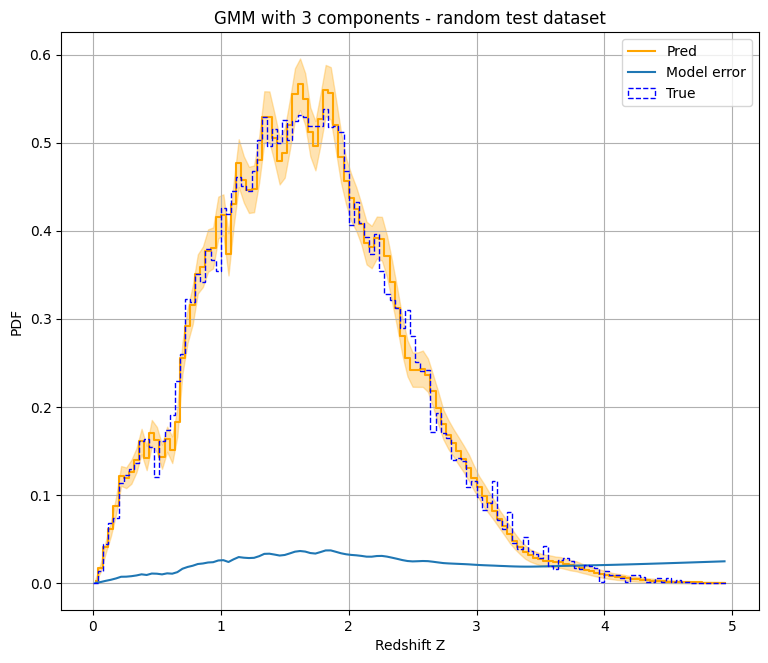

Chi^2: 2769.3598962646956


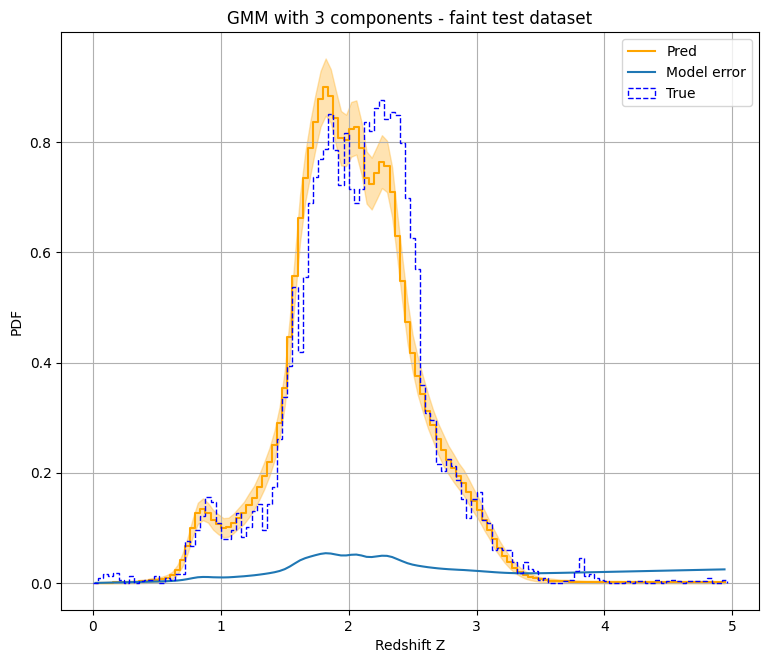

In [150]:
modelPathGMM = f"../../models/experiment2/MG_{config["num_components"]}_components_3/variables/variables"
gmm_global_std_history = evaluate_model(models.MixtureGaussian, modelPathGMM, "GMM", config, X_test, y_test, "random")
_ = evaluate_model(models.MixtureGaussian, modelPathGMM, "GMM", config, X_faint, y_faint, "faint")

/home/kdrabicki/anaconda3/envs/cpu_env/lib/python3.12/site-packages/tensorflow_probability/python/layers/util.py:99: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/home/kdrabicki/anaconda3/envs/cpu_env/lib/python3.12/site-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
/home/kdrabicki/anaconda3/envs/cpu_env/lib/python3.12/site-packages/tensorflow_probability/python/layers/util.py:109: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_vari

Chi^2: 516.4080925419673


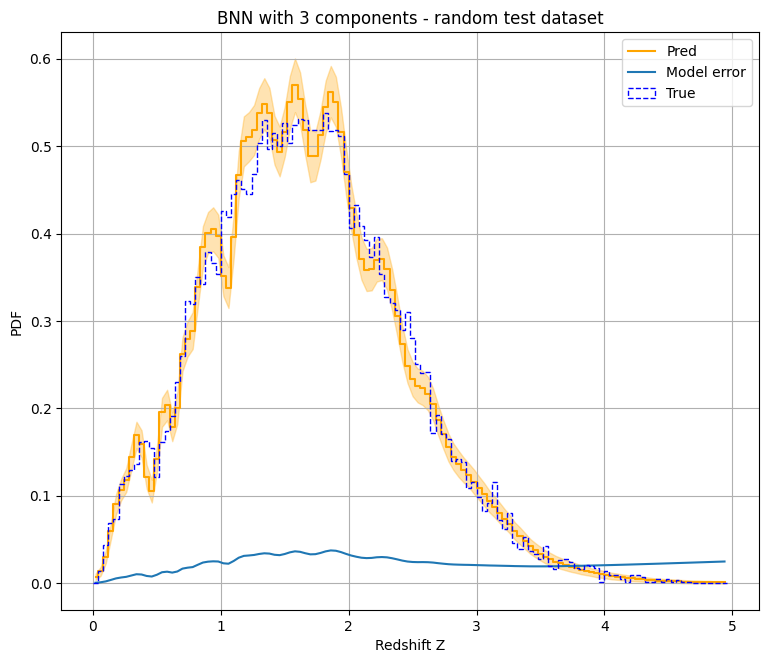

/home/kdrabicki/anaconda3/envs/cpu_env/lib/python3.12/site-packages/tensorflow_probability/python/layers/util.py:99: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/home/kdrabicki/anaconda3/envs/cpu_env/lib/python3.12/site-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
/home/kdrabicki/anaconda3/envs/cpu_env/lib/python3.12/site-packages/tensorflow_probability/python/layers/util.py:109: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_vari

Chi^2: 1984.0307786811923


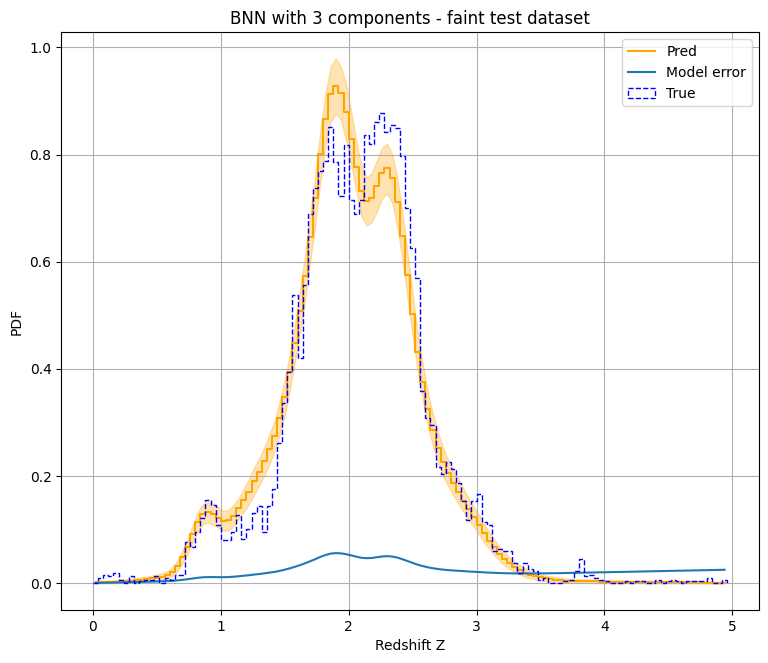

In [144]:
modelPathBNN = f"../../models/experiment2/BNN_last_3_layers_2/variables/variables"
bnn_global_std_history = evaluate_model(models.BayesianNN, modelPathBNN, "BNN", config, X_test, y_test, "random")
_ = evaluate_model(models.BayesianNN, modelPathBNN, "BNN", config, X_faint, y_faint, "faint")

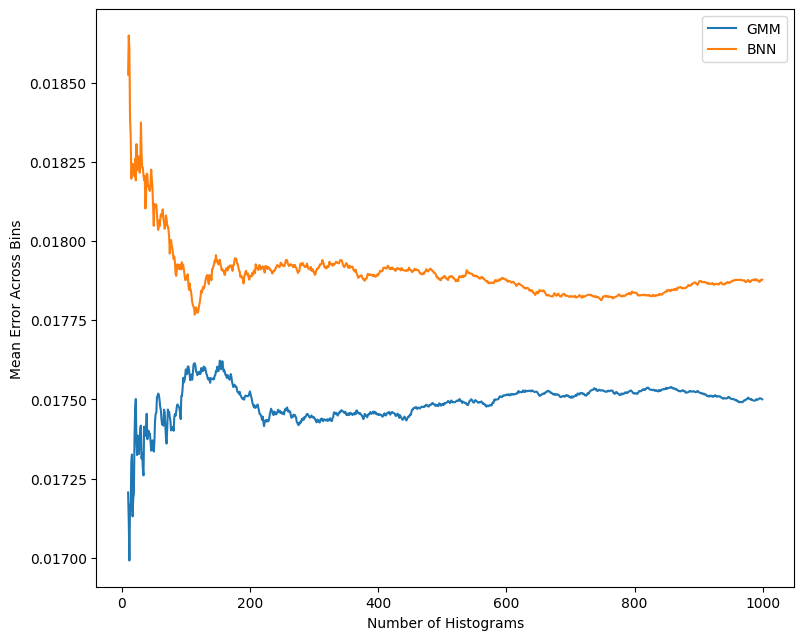

In [151]:
plot_std_history(gmm_global_std_history, bnn_global_std_history)